In [1]:
%matplotlib notebook
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as sstats # computing correlation coefficient
import matplotlib.pyplot as plt
from sklearn.svm import SVC,LinearSVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
import time

# Correlogram showing linear correlation coefficient
def corrCoefficient(x, y, **kws):
    r, _ = sstats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(u"\u03C1 = {:.2f}".format(r), # unicode code for lowercase rho (ρ)
                xy=(.1, .9), xycoords=ax.transAxes)

# import iris data to play with
iris = load_iris()
    


<IPython.core.display.Javascript object>


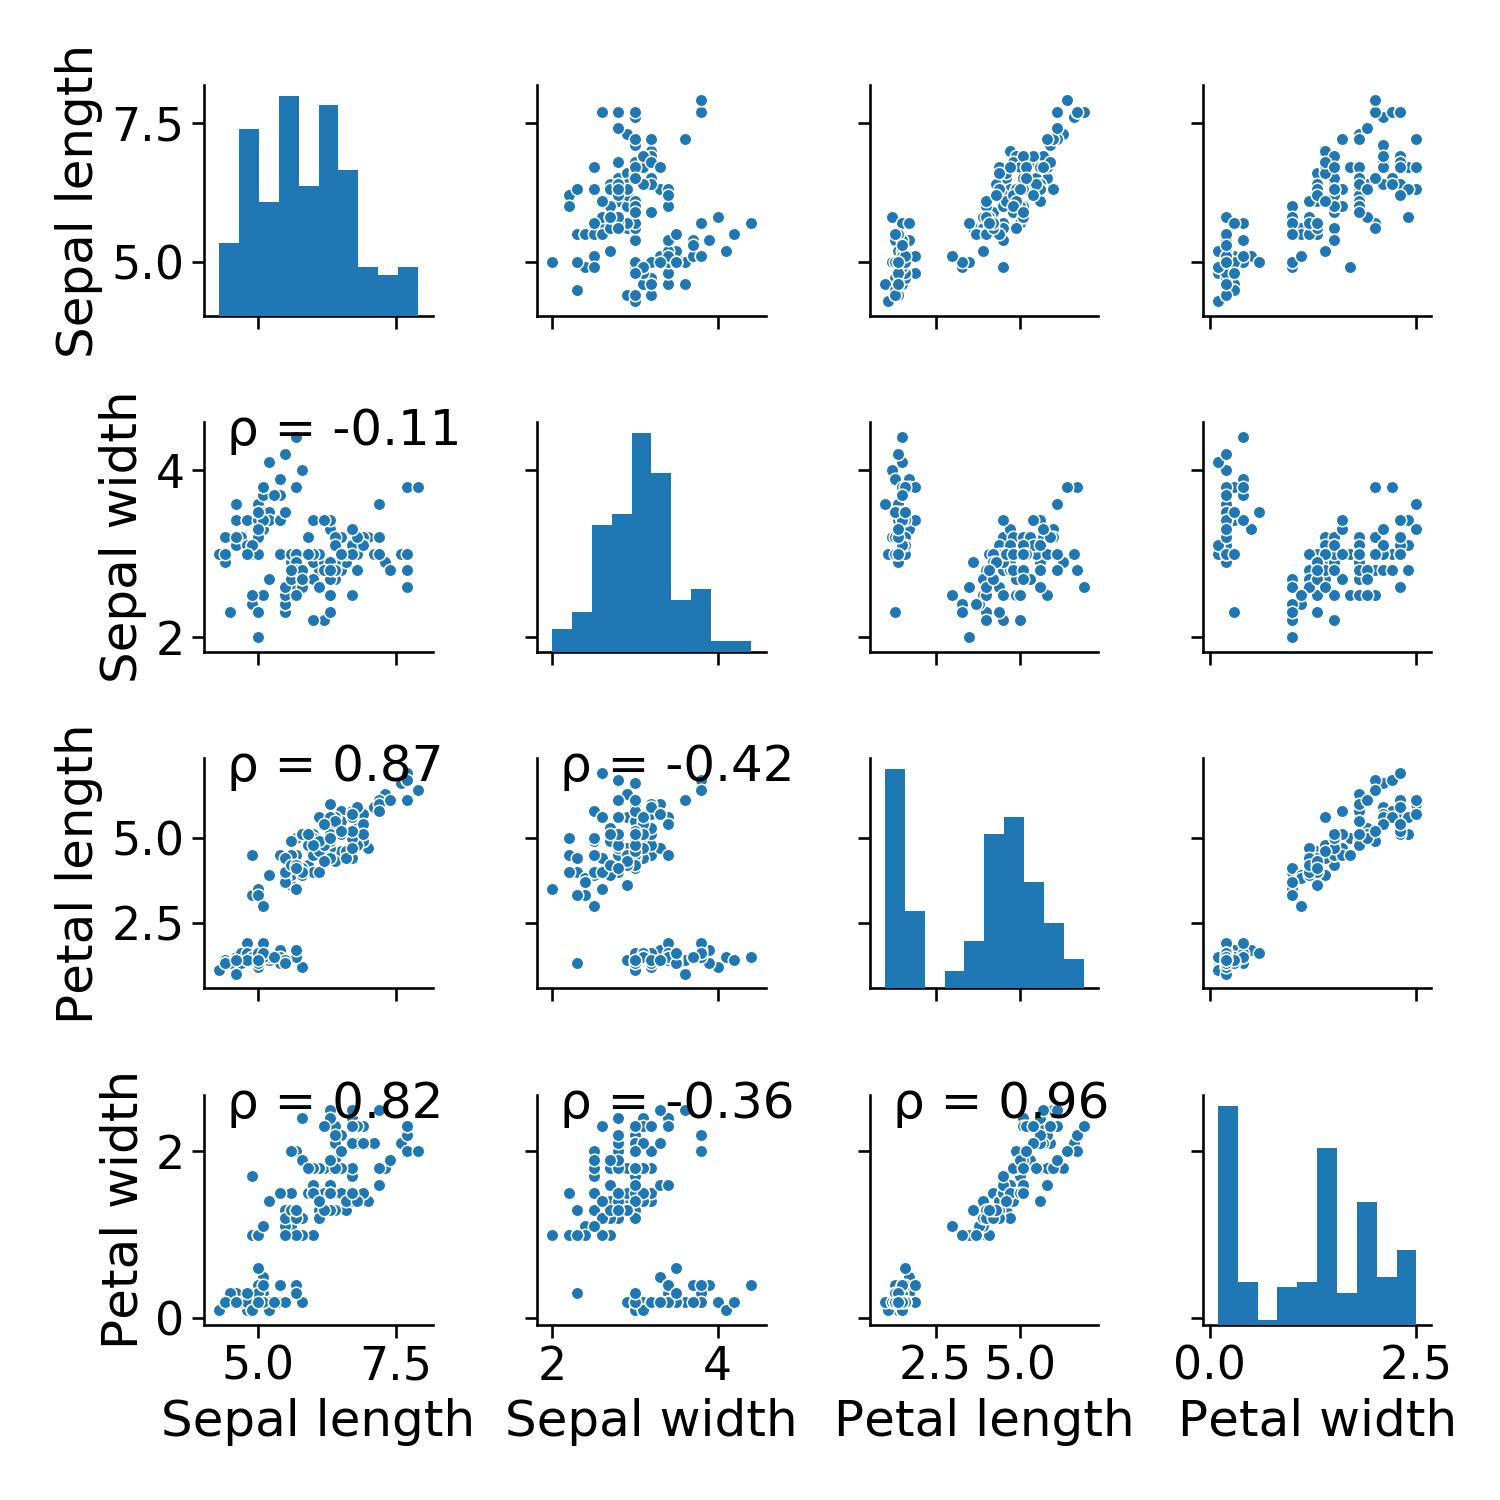

In [4]:
# Plot correlogram
varNames=['Sepal length', 'Sepal width', 'Petal length', 'Petal width']
data=pd.DataFrame(iris.data,columns=varNames)  
sns.set_context("notebook",font_scale=2)
plot=sns.pairplot(data)
plot.map_lower(corrCoefficient)

In [2]:
numRun=1000
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
numMetrics=2 # accuracy and loss
models = (SVC(kernel='linear',C=C),
          GaussianNB(),
          KNeighborsClassifier(n_neighbors=3),     
          DecisionTreeClassifier(),
          RandomForestClassifier(n_estimators=100),
          QuadraticDiscriminantAnalysis())

# 80-20 hold out with random split: 20% test set
test_fraction=0.2
numModel=len(models)
testLabelSum=np.zeros(shape=(numRun,1))
validationMetrics=np.zeros(shape=(numRun,numModel,numMetrics))

start_time = time.time()
for i in range(numRun): # loop of numRun
    # Random split: specify random_state for the random seed when needed
    x_train ,x_test,y_train, y_test = train_test_split(iris.data,iris.target,test_size=test_fraction) 
    testLabelSum[i]=np.sum(y_test)
    for j in range(numModel):
        clf=models[j]
        # training
        clf.fit(x_train, y_train)
        validationMetrics[i,j,0]=clf.score(x_test,y_test)
        if (j==0):
            validationMetrics[i,j,1]=metrics.hinge_loss(y_test,clf.decision_function(x_test))
        else:
            validationMetrics[i,j,1]=metrics.log_loss(y_test,clf.predict_proba(x_test))
    if (i%(numRun/10)==0):
        print(str(i))
runTime=time.time() - start_time
print('Run time ' + str(runTime)+' second')

0
100
200
300
400
500
600
700
800
900
Run time 122.82866835594177 second


<IPython.core.display.Javascript object>


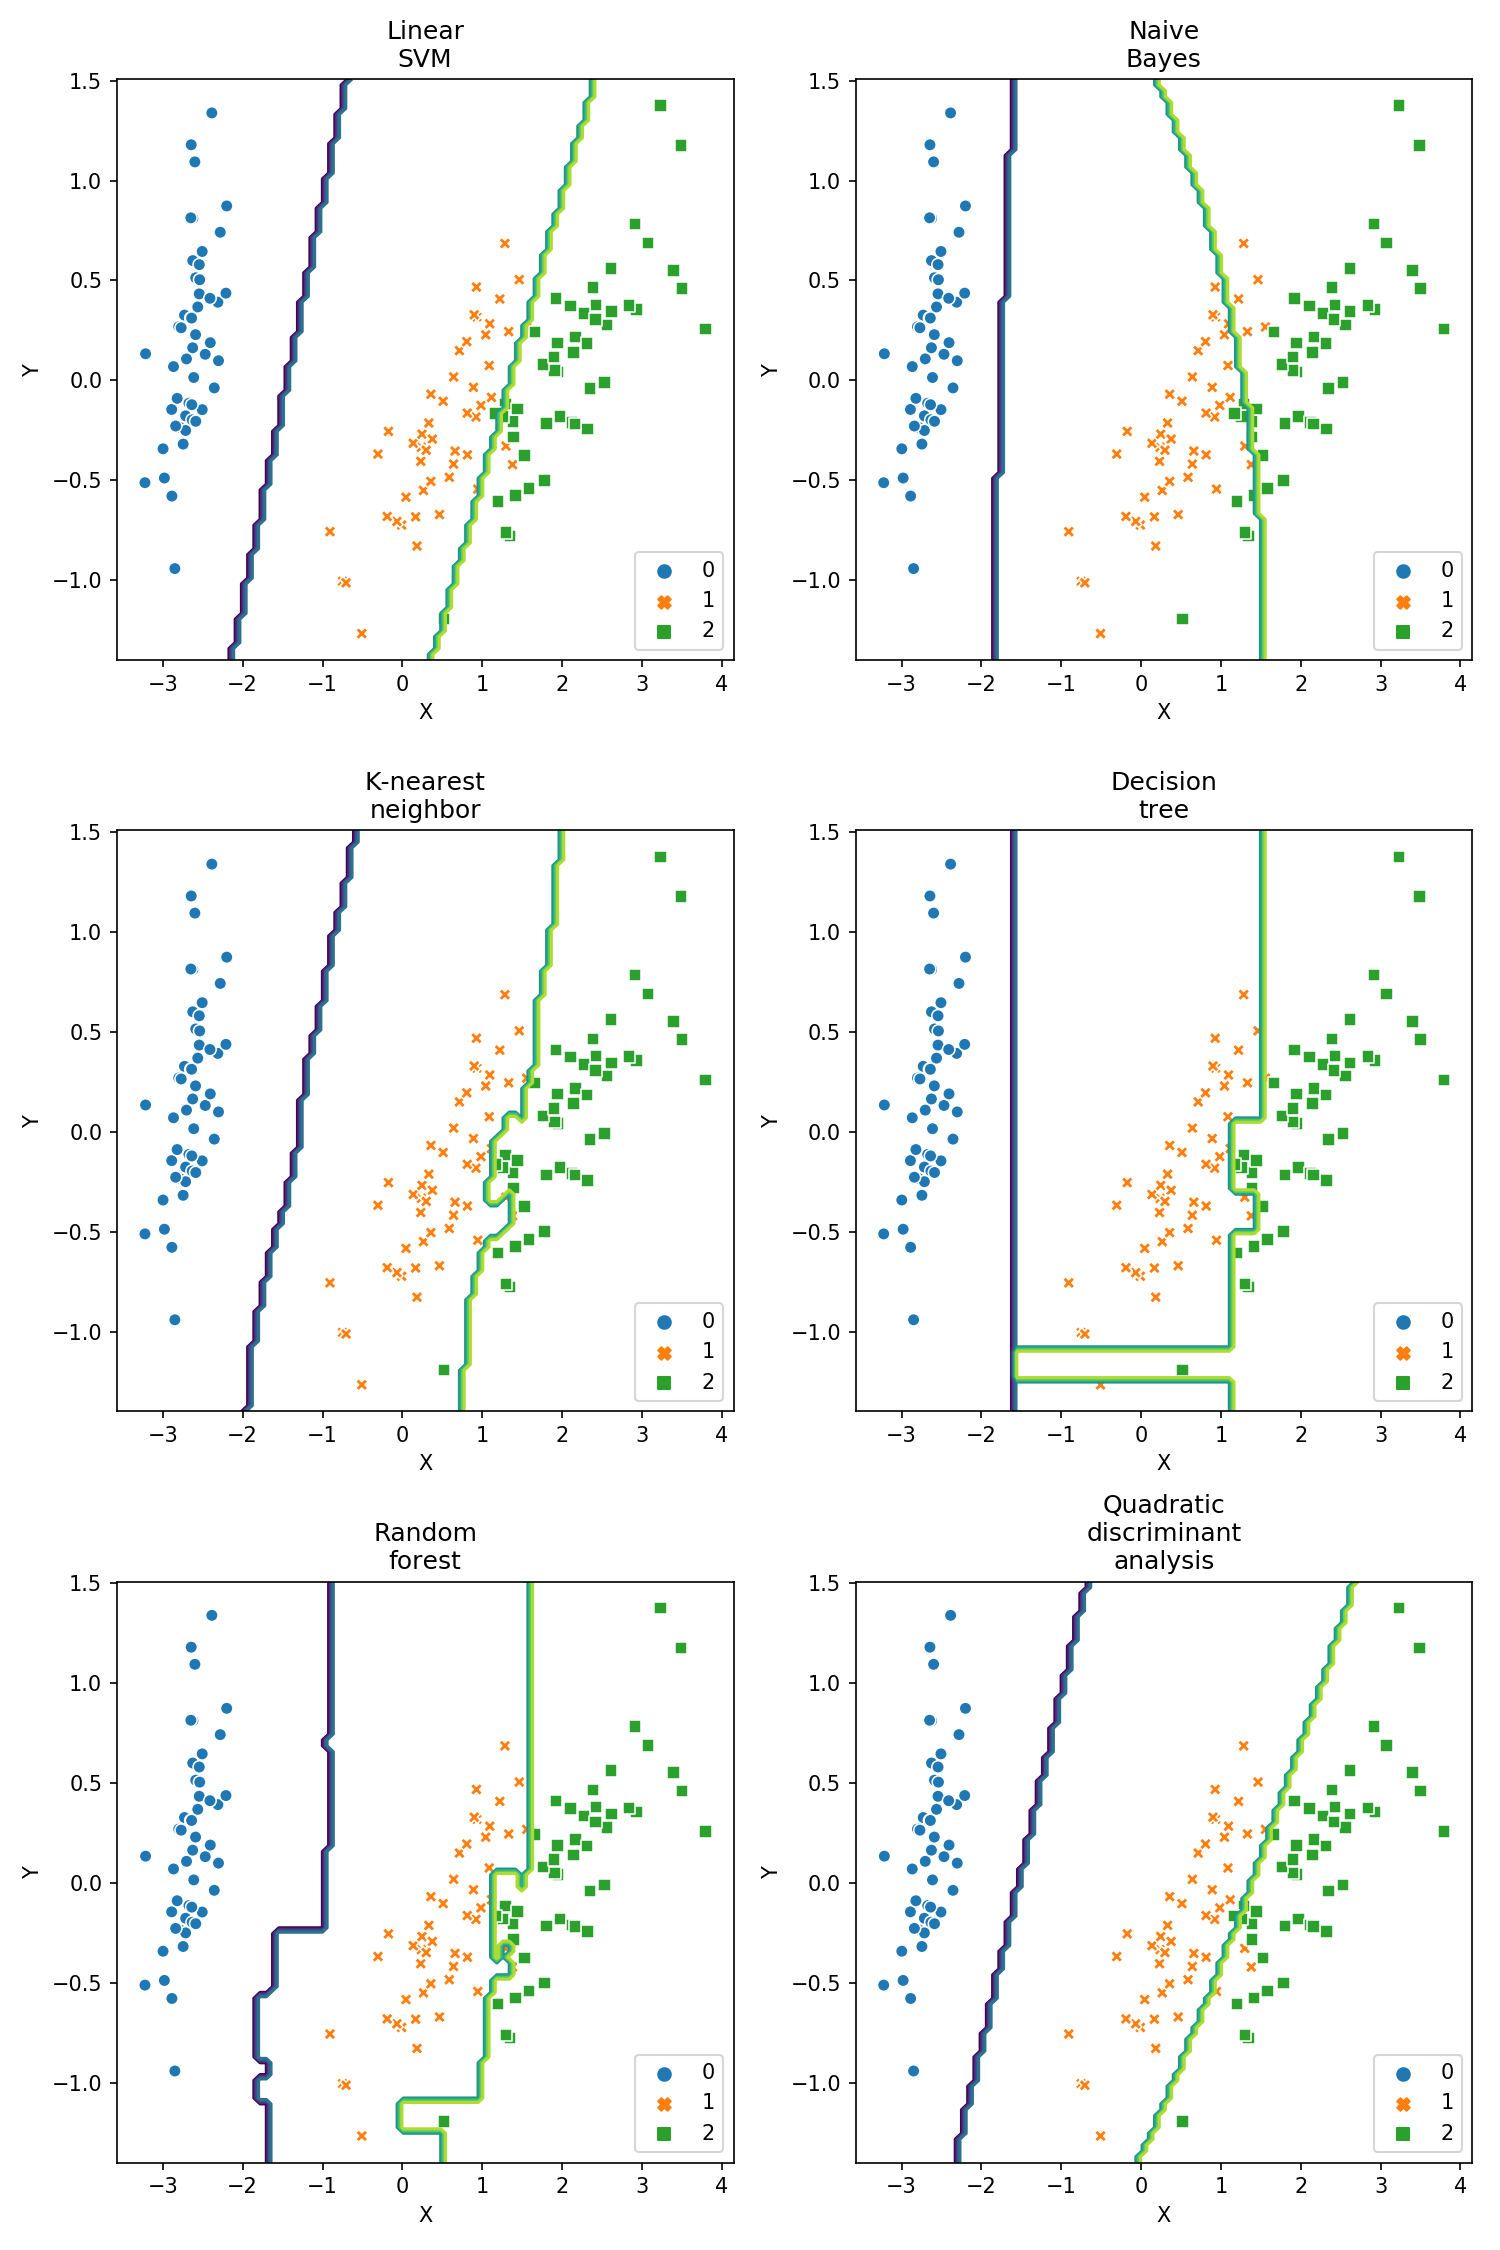

In [97]:
modelNames=['Linear\nSVM','Naive\nBayes','K-nearest\nneighbor','Decision\ntree','Random\nforest','Quadratic\ndiscriminant\nanalysis']

import sys
sys.path.append('library')
from Yuan import crossvalidation_auc,mymeshgrid,decisionContour

# Plot decision boundary on 2 principal components
pca=PCA(n_components=2).fit(iris.data)
components = pd.DataFrame(pca.transform(iris.data),columns=['X','Y'])

#clf = SVC(kernel='linear',gamma='auto')
# Degree of polynomial should not be even
#clf = SVC(kernel='poly',degree=3,gamma='auto')
#clf=QuadraticDiscriminantAnalysis()
#clf=GaussianNB()
#clf=RandomForestClassifier()

numRow=3
numCol=2
plt.figure(figsize=(numCol*5,numRow*5))
for j in range(numModel):
    clf=models[j]
    # training
    clf.fit(components , iris.target)
    plt.subplot(numRow,numCol,j+1)
    ax=sns.scatterplot(x="X", y="Y", data=components,hue=iris.target,style=iris.target,palette=sns.color_palette(n_colors=3))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model: 100 steps on each dimension
    XX, YY = meshGrid(xlim,ylim,100)
    # Plot the decision boundaries
    decisionContour(ax, clf, XX, YY)
    plt.title(modelNames[j])
    
plt.show()
# Make the figure fit
plt.tight_layout()

In [52]:
import importlib
import Yuan
importlib.reload(Yuan)

<module 'Yuan' from 'library\\Yuan.py'>

<IPython.core.display.Javascript object>


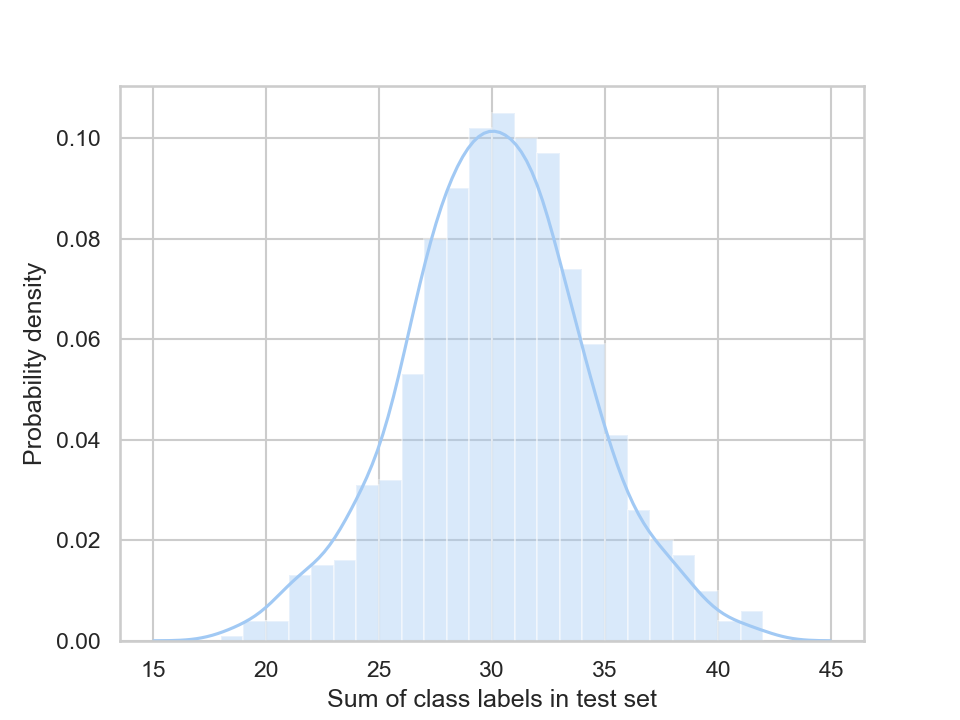

C:\Users\ychen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [45]:
plt.figure()
plot=sns.distplot(testLabelSum.flatten())
plot.set(xlabel='Sum of class labels in test set', ylabel='Probability density');

<IPython.core.display.Javascript object>


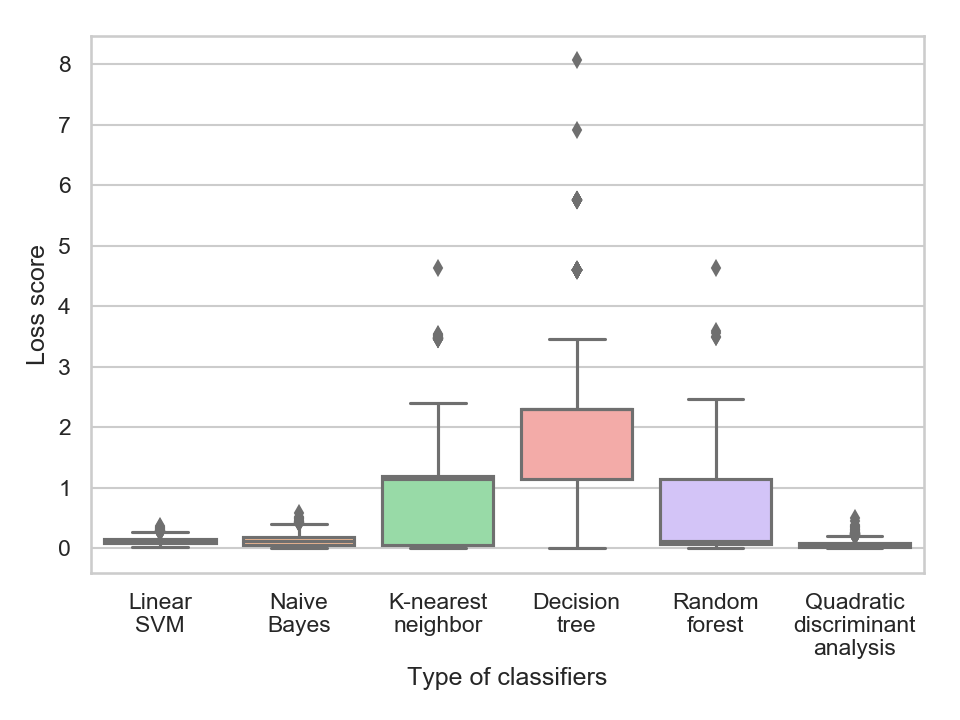

In [46]:
# Grouped boxplot
plt.figure()
sns.set(style="whitegrid", palette="pastel")
sns.set_context("notebook")
# Create data frame with model names as variable names
plotData = pd.DataFrame(validationMetrics[:,0:7,1],columns=modelNames)
plot=sns.boxplot(data=plotData)
plot.set(xlabel='Type of classifiers', ylabel='Loss score');
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


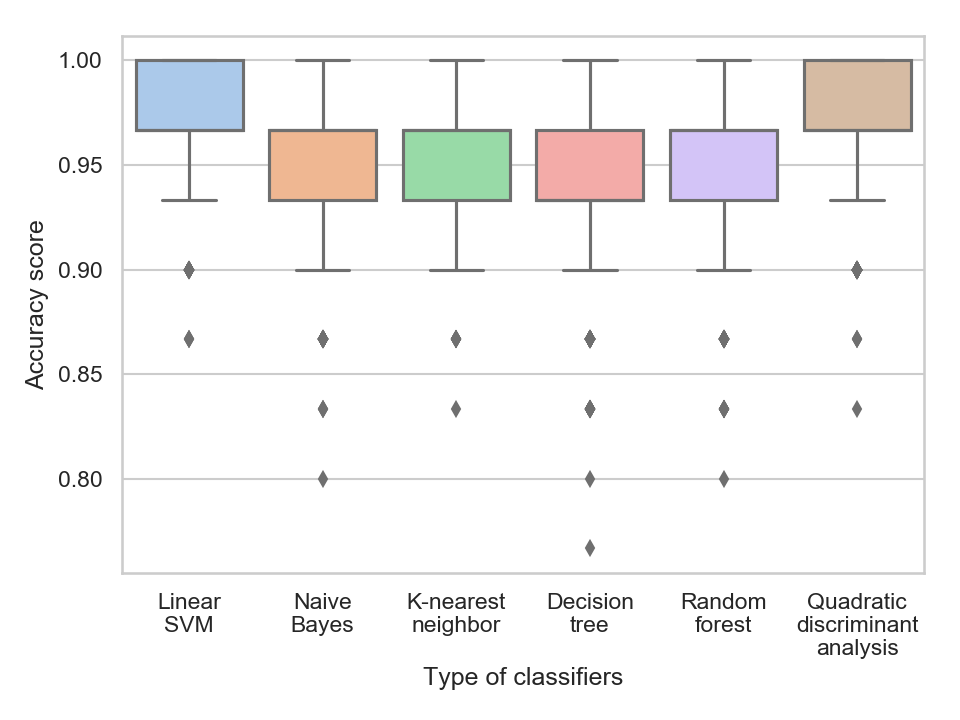

In [47]:
# Grouped boxplot
plt.figure()
# Create data frame with model names as variable names
plotData = pd.DataFrame(validationMetrics[:,:,0],columns=modelNames)
plot=sns.boxplot(data=plotData)
plot.set(xlabel='Type of classifiers', ylabel='Accuracy score');
plt.tight_layout()
plt.show()

In [48]:
import re
for i in range(numModel):
    modelName=modelNames[i]
    modelName=re.sub('\n', ' ',modelName)
    print((modelName+":").ljust(40)+"{0:.3f}".format(np.mean(validationMetrics[:,i,0]))+"\t"+"{0:.3f}".format(np.std(validationMetrics[:,i,0]))+"\t"+"{0:.3f}".format(np.mean(validationMetrics[:,i,1]))+"\t"+"{0:.3f}".format(np.std(validationMetrics[:,i,1])))

Linear SVM:                             0.977	0.027	0.126	0.054
Naive Bayes:                            0.953	0.035	0.136	0.099
K-nearest neighbor:                     0.961	0.030	0.879	0.857
Decision tree:                          0.945	0.038	1.896	1.317
Random forest:                          0.948	0.036	0.417	0.608
Quadratic discriminant analysis:        0.973	0.029	0.064	0.063
